<a href="https://colab.research.google.com/github/baalasangar/MLAI/blob/master/13_Capstone/Model_building_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective:
 - Train  a neural network model which can predict is the patience is affected or not.
 - sample images are taken from the population ( considering the distripution of the data like *****)
 - sample  Train Image - 500 postive images 500 negative images
 - sample Test Image - 50 postive and 50 negative images
 - xray images of 512 * 512 are the input to the model
 - evaluation metrics - recall
 - conclution is performed with comparing different models ( classification metrix, loss vs accuracy & classification report ) 






### Load lib and data

In [238]:
!pip install pydicom

In [239]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [240]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score,precision_score,roc_auc_score,accuracy_score,confusion_matrix,roc_curve,plot_roc_curve


import cv2
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import pickle

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s :: %(levelname)s :: %(message)s')



import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,MaxPool2D,GlobalMaxPooling2D,Input
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [241]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [242]:
META_DATA = "/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/final_data.csv"
DATA_ROOT_PATH = "/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/"


META_DATA,DATA_ROOT_PATH

('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/final_data.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/')

In [243]:
metadata_df = pd.read_csv(META_DATA)
metadata_df.drop(labels= ["Unnamed: 0"], axis=1,inplace=True)
metadata_df.head()

,patientId,x,y,width,height,Target,class,filepath,Train_or_Test,area,age,sex,ViewPosition,BodyPartExamined
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,51,F,PA,CHEST
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,48,F,PA,CHEST
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,19,M,AP,CHEST
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,28,M,PA,CHEST
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,80727.0,32,F,AP,CHEST


### sample data for model building
 - from EDA , ViewPosition  ( PA and AP  ) influence the orientation of the xray . So the sampling is done by considering  ViewPosition

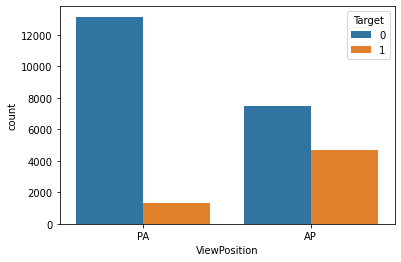

In [244]:
sns.countplot(data = metadata_df[["patientId","Target","ViewPosition"]].drop_duplicates(),x="ViewPosition",hue="Target")
plt.show()

In [245]:
SAMPLE_SIZE = 650
sampled_metadata = pd.DataFrame(columns=["patientId","Target","ViewPosition","filepath"])

In [246]:
pa_count = metadata_df.query("ViewPosition == 'PA' & Target == 1")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]
ap_count = metadata_df.query("ViewPosition == 'AP' & Target == 1")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]

pa_count_sample_size = int(round(pa_count / (pa_count+ap_count),2) * SAMPLE_SIZE)
ap_count_sample_size = int(round(ap_count / (pa_count+ap_count),2) * SAMPLE_SIZE)

print(pa_count_sample_size,ap_count_sample_size)

sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'PA' & Target == 1")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=pa_count_sample_size,random_state=RANDOM_SEED))
sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'AP' & Target == 1")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=ap_count_sample_size,random_state=RANDOM_SEED))


143 507


In [247]:
pa_count = metadata_df.query("ViewPosition == 'PA' & Target == 0")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]
ap_count = metadata_df.query("ViewPosition == 'AP' & Target == 0")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]

pa_count_sample_size = int(round(pa_count / (pa_count+ap_count),2) * SAMPLE_SIZE)
ap_count_sample_size = int(round(ap_count / (pa_count+ap_count),2) * SAMPLE_SIZE)

print(pa_count_sample_size,ap_count_sample_size)

sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'PA' & Target == 0")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=pa_count_sample_size,random_state=RANDOM_SEED))
sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'AP' & Target == 0")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=ap_count_sample_size,random_state=RANDOM_SEED))


416 234


In [248]:
sampled_metadata.reset_index(drop=True,inplace=True )
print(sampled_metadata.shape)
sampled_metadata.head()

(1300, 4)


,patientId,Target,ViewPosition,filepath
0,e18c7203-a029-4cf4-8151-2bc2460c390c,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
1,18ce990f-bea9-4174-a6a2-8f61c4517b24,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
2,068b608d-f71c-4859-b909-62c1665b507f,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
3,9fa17c26-8aae-4dd6-af8a-5750f042adf9,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
4,722503cf-a801-415b-a10e-848bfea55911,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...


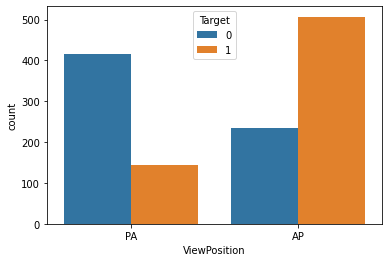

In [249]:
# distibution of the sample dataset similar to the population 

sns.countplot(data = sampled_metadata,x="ViewPosition",hue="Target")

### reading , postprocessing, reshaping Img

In [250]:
### reading the image and storing it as pickle for later access

# def read_img(index_list):
#   image_list = []
#   label_list = []
#   for index in index_list:
#     filePath = sampled_metadata.loc[index]["filepath"]
#     image_list.append(dicom.dcmread(filePath).pixel_array)
#     label_list.append(sampled_metadata.loc[index]["Target"])
#   return image_list,label_list

# index_list = list(sampled_metadata.index)
# X,y = read_img(index_list)
# X = np.array(X)
# y = np.array(y)

# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/image_list.pkl','wb') as f:
#   pickle.dump(X, f)

# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/label_list.pkl','wb') as f:
#   pickle.dump(y, f)  

#### reading img

In [251]:
with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/image_list.pkl','rb') as f:
  X_image_list = pickle.load(f)

with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/label_list.pkl','rb') as f:
  y_lable_value = pickle.load(f)

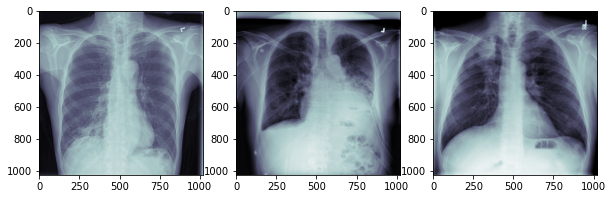

In [252]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_list[i],"bone") 
plt.show()

#### CLAHE processing - improve the contrast of images
 - Contrast Limited Adaptive Histogram Equalization (CLAHE) to equalize images. CLAHE is a variant of Adaptive histogram equalization (AHE) which takes care of over-amplification of the contrast
 

In [253]:
def CLAHEprocessing(img):
  clahe = cv2.createCLAHE(clipLimit = 5)
  clahe_img = clahe.apply(img) + 30
  return clahe_img

X_image_list = [CLAHEprocessing(img) for img in X_image_list]

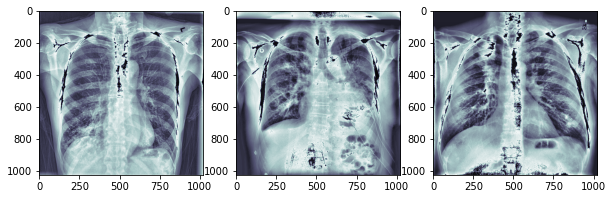

In [254]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_list[i],"bone") 
plt.show()

#### reshaping image

In [255]:
IMG_HEIGHT_WIDTH = 256
# resizing the image 512 * 512
X_image_reshaped = [cv2.resize(img,(IMG_HEIGHT_WIDTH,IMG_HEIGHT_WIDTH)) for img in X_image_list]
print("Shape of the image after resizing", X_image_reshaped[0].shape)

Shape of the image after resizing (256, 256)


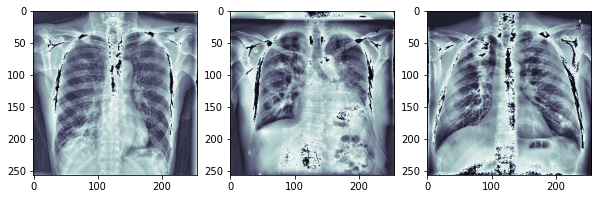

In [256]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_reshaped[i],"bone") 
plt.show()

In [257]:
# index = list(sampled_metadata.query("patientId == 'e18c7203-a029-4cf4-8151-2bc2460c390c'").index)
# testpath = sampled_metadata.loc[index[0]]["filepath"]
# img = dicom.dcmread(testpath).pixel_array
# # logging.info(testpath, testpath.dtype)
# # img = dicom.dcmread(testpath).pixel_array
# print(img.shape,img.min(),img.max())
# plt.imshow(img,"bone") 
# plt.show()

# img = cv2.resize(img,(512,512),interpolation = cv2.INTER_AREA)
# plt.imshow(img,"bone") 
# plt.show()
# print(img.shape,img.min(),img.max())


# clahe = cv2.createCLAHE(clipLimit = 5)
# clahe_img = clahe.apply(img) + 30
# plt.imshow(clahe_img,"bone") 
# plt.show()


### Train & test data split

In [258]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_image_reshaped), y_lable_value, test_size=0.2, random_state=RANDOM_SEED,stratify=y_lable_value)

In [259]:
print("X_train data shape ", X_train.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test.shape)
print("y_test data shape ", y_test.shape)


X_train data shape  (1040, 256, 256)
y_train data shape  (1040,)
X_test data shape  (260, 256, 256)
y_test data shape  (260,)


In [260]:
print("distribution in Train \n", np.array(np.unique(y_train, return_counts=True)).T)
print("distribution in Test \n", np.array(np.unique(y_test, return_counts=True)).T)

distribution in Train 
 [[  0 520]
 [  1 520]]
distribution in Test 
 [[  0 130]
 [  1 130]]


### Normalize the image

In [261]:
## Normalize 
X_train = X_train /  255
X_test = X_test /  255

print("X_train min / max ", X_train.min(),X_train.max())
print("X_test min / max ", X_test.min(),X_test.max())

X_train min / max  0.0 1.0
X_test min / max  0.0 1.0


### Model Building
 - Inscepton Model ( transfer learning ) 
 - Resnet ( transfer learning ) 
 - Model from scratch
 

In [262]:
metrics_data = pd.DataFrame(columns=["model","train_score","test_score","auc","recall","precision","cm"])

def get_metrics(model_name):
  metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_predict),2),
    "auc":round(roc_auc_score(y_test,y_predict),2),
    "recall":round(recall_score(y_test,y_predict),2),
    "precision":round(precision_score(y_test,y_predict),2),
    "cm":confusion_matrix(y_test,y_predict)
    }
  return metric


def plot_roccurve(y_true, y_score):
    """plot_roc_curve."""
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_true, y_score)
    plt.plot(false_positive_rate, true_positive_rate, lw=2, color='navy')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.grid()
    plt.title('Receiver operating characteristic AUC={0:0.2f}'.format(
        roc_auc_score(y_true, y_score))) 
    return plt


#### SVC + PCA

In [263]:
### Reshape input for  SVC 
X_train_svc = X_train.reshape(X_train.shape[0],IMG_HEIGHT_WIDTH*IMG_HEIGHT_WIDTH)
print("X_train_svc data shape ", X_train_svc.shape)

X_test_svc= X_test.reshape(X_test.shape[0],IMG_HEIGHT_WIDTH*IMG_HEIGHT_WIDTH)
print("X_test_svc data shape ", X_test_svc.shape)

print("y_train data shape ", y_train.shape)
print("y_test data shape ", y_test.shape)


X_train_svc data shape  (1040, 65536)
X_test_svc data shape  (260, 65536)
y_train data shape  (1040,)
y_test data shape  (260,)


In [264]:
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                 y_train)
# class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# print("class_weights", class_weights_dict)

In [265]:
pca = PCA(0.95)
estimator = SVC(kernel="rbf")
param_grid = {    
    "estimator__C":[1,10,50,100],
    "estimator__gamma":[0.001,0.01,0.1],

}
pipe = Pipeline(steps=[('pca', pca), ('estimator', estimator)])
gridsearch = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = "recall")

gridsearch.fit(X_train_svc,y_train)
y_predict = gridsearch.predict(X_test_svc)
y_train_predict = gridsearch.predict(X_train_svc)

In [266]:
model_name = "SVC+PCA"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_predict),2),
    "auc":round(roc_auc_score(y_test,y_predict),2),
    "recall":round(recall_score(y_test,y_predict),2),
    "precision":round(precision_score(y_test,y_predict),2),
    "cm":confusion_matrix(y_test,y_predict)
    }
metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,auc,recall,precision,cm
0,SVC+PCA,0.99,0.68,0.68,0.68,0.67,"[[87, 43], [41, 89]]"


Best param  {'estimator__C': 1, 'estimator__gamma': 0.001}
 



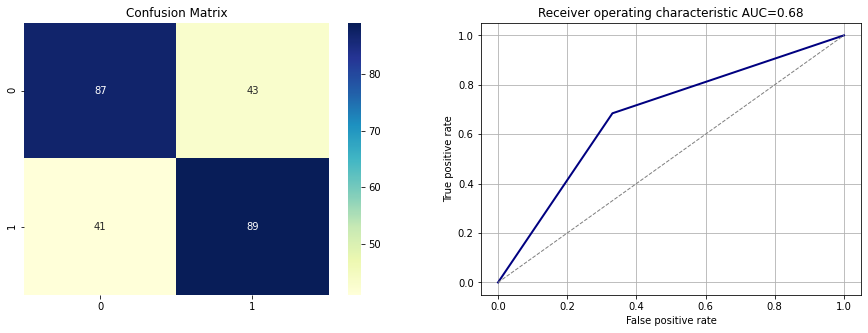

In [267]:
print("Best param ", gridsearch.best_params_)
print(" \n")

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,ax=ax[0],cmap="YlGnBu")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_test,y_predict)
plt.show() 


#### Neural Network

In [268]:
# def nn_model_dropout(kernel_initializer = "normal"):
#     model = Sequential()
#     model.add(Flatten())

#     model.add(Dense(512, activation = "relu"))   
#     model.add(BatchNormalization())

#     model.add(Dense(256, activation = "relu"))   
#     model.add(BatchNormalization())
    
#     model.add(Dense(128, activation = "relu"))   
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))

#     model.add(Dense(64, activation = "relu"))   
#     model.add(BatchNormalization())

#     model.add(Dense(32, activation = "relu"))   
#     model.add(BatchNormalization())
    
#     model.add(Dense(1, activation = "sigmoid"))
#     return model


def nn_model():
  inputs = Input(shape=(IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH))
  x = Flatten()(inputs)
  x = Dense(units=512, activation='relu')(x)
  #x = Dropout(rate=0.7)(x)
  x = Dense(units=128, activation='relu')(x)  
  #x = Dropout(rate=0.5)(x)
  x = Dense(units=64, activation='relu')(x)

  x = Dense(units=32, activation='relu')(x)

  x = Dense(units=16, activation='relu')(x)
  x = Dropout(rate=0.1)(x)

  output = Dense(units=1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=output)
  return model



nn_model = nn_model()
optimizer = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.001)

nn_model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy",
                              tf.keras.metrics.Precision(name="precision"),
                              tf.keras.metrics.Recall(name="recall")])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.01, 
                                            min_lr=0.0001)

fit_data = nn_model.fit(X_train, y_train, validation_data=(X_test,y_test),
                           batch_size = 32, epochs = 100, verbose = 1,callbacks=[es,learning_rate_reduction])

Epoch 1/100
33/33 [==============================] - 1s 20ms/step - loss: 4.4569 - accuracy: 0.4942 - precision: 0.4942 - recall: 0.4942 - val_loss: 2.0589 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/100
33/33 [==============================] - 0s 10ms/step - loss: 1.7379 - accuracy: 0.5135 - precision: 0.5127 - recall: 0.5423 - val_loss: 0.6779 - val_accuracy: 0.5808 - val_precision: 0.5459 - val_recall: 0.9615
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 0.9113 - accuracy: 0.5635 - precision: 0.5660 - recall: 0.5442 - val_loss: 1.3505 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 0.9431 - accuracy: 0.5452 - precision: 0.5441 - recall: 0.5577 - val_loss: 0.6597 - val_accuracy: 0.6615 - val_precision: 0.7143 - val_recall: 0.5385
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 0.7568 - accuracy: 0.5606 - pr

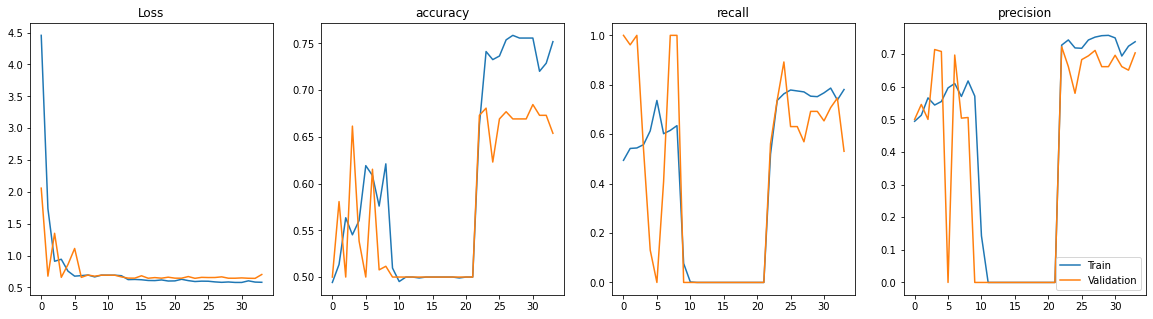

In [269]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")


ax[2].plot(fit_data.history['recall'],label="Train")
ax[2].plot(fit_data.history['val_recall'],label="Validation")
ax[2].set_title("recall")

ax[3].plot(fit_data.history['precision'],label="Train")
ax[3].plot(fit_data.history['val_precision'],label="Validation")
ax[3].set_title("precision")
plt.legend()

plt.show() 

In [270]:
y_train_predict =  nn_model.predict(X_train)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_predict = nn_model.predict(X_test)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]

model_name = "NN"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_predict),2),
    "auc":round(roc_auc_score(y_test,y_predict),2),
    "recall":round(recall_score(y_test,y_predict),2),
    "precision":round(precision_score(y_test,y_predict),2),
    "cm":confusion_matrix(y_test,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,auc,recall,precision,cm
1,NN,0.73,0.65,0.65,0.53,0.7,"[[101, 29], [61, 69]]"


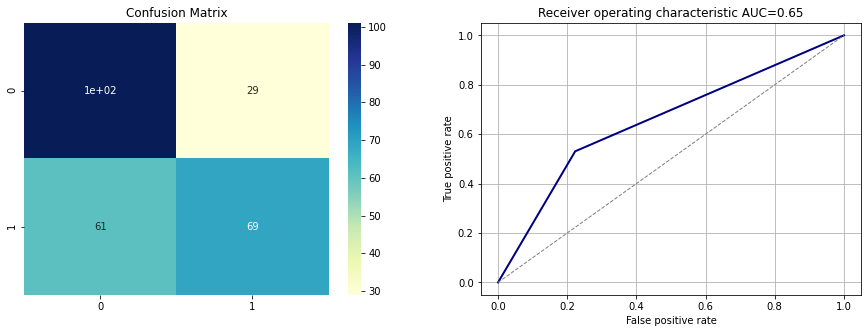

In [271]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,ax=ax[0],cmap="YlGnBu")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_test,y_predict)
plt.show() 

#### CNN ( with out transfer learning )

In [272]:
def cnn_model():
  inputs = Input(shape=(IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH,1))

  x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
  x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
  x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
  x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
  x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
  x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

  x = Flatten()(inputs)
  x = Dense(units=512, activation='relu')(x)
  x = Dense(units=128, activation='relu')(x)  
  x = Dense(units=64, activation='relu')(x)
  x = Dense(units=32, activation='relu')(x)
  x = Dense(units=16, activation='relu')(x)
  x = Dropout(rate=0.1)(x)

  output = Dense(units=1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=output)
  return model

cnn_model = cnn_model()
optimizer = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.001)

cnn_model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy",
                              tf.keras.metrics.Precision(name="precision"),
                              tf.keras.metrics.Recall(name="recall")])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.01, 
                                            min_lr=0.0001)

fit_data = cnn_model.fit(X_train, y_train, validation_data=(X_test,y_test),
                           batch_size = 32, epochs = 100, verbose = 1,callbacks=[es,learning_rate_reduction])

Epoch 1/100
33/33 [==============================] - 1s 20ms/step - loss: 2.8620 - accuracy: 0.5135 - precision: 0.5123 - recall: 0.5596 - val_loss: 0.6588 - val_accuracy: 0.6654 - val_precision: 0.6838 - val_recall: 0.6154
Epoch 2/100
33/33 [==============================] - 0s 10ms/step - loss: 0.8691 - accuracy: 0.5596 - precision: 0.5598 - recall: 0.5577 - val_loss: 0.7535 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 0.7163 - accuracy: 0.6135 - precision: 0.6101 - recall: 0.6288 - val_loss: 1.1313 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 0.7221 - accuracy: 0.5760 - precision: 0.5516 - recall: 0.8115 - val_loss: 0.6292 - val_accuracy: 0.6538 - val_precision: 0.7174 - val_recall: 0.5077
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 0.6469 - accuracy: 0.6375 - pr

In [276]:
y_train_predict =  cnn_model.predict(X_train)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_predict = cnn_model.predict(X_test)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]

model_name = "CNN"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_predict),2),
    "auc":round(roc_auc_score(y_test,y_predict),2),
    "recall":round(recall_score(y_test,y_predict),2),
    "precision":round(precision_score(y_test,y_predict),2),
    "cm":confusion_matrix(y_test,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,auc,recall,precision,cm
2,CNN,0.73,0.65,0.65,0.53,0.70,"[[101, 29], [61, 69]]"
3,CNN,0.73,0.68,0.68,0.60,0.71,"[[98, 32], [52, 78]]"


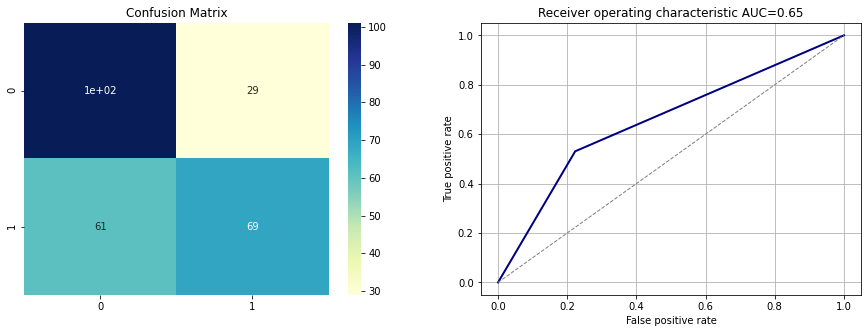

In [274]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,ax=ax[0],cmap="YlGnBu")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_test,y_predict)
plt.show() 

In [275]:
metrics_data

,model,train_score,test_score,auc,recall,precision,cm
0,SVC+PCA,0.99,0.68,0.68,0.68,0.67,"[[87, 43], [41, 89]]"
1,NN,0.73,0.65,0.65,0.53,0.70,"[[101, 29], [61, 69]]"
2,CNN,0.73,0.65,0.65,0.53,0.70,"[[101, 29], [61, 69]]"
